In [73]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import edhec_risk_kit_111 as erk
hfi = erk.get_hfi_returns()
hfi.head()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,Convertible Arbitrage,CTA Global,Distressed Securities,Emerging Markets,Equity Market Neutral,Event Driven,Fixed Income Arbitrage,Global Macro,Long/Short Equity,Merger Arbitrage,Relative Value,Short Selling,Funds Of Funds
date,,,,,,,,,,,,,
1997-01,0.0119,0.0393,0.0178,0.0791,0.0189,0.0213,0.0191,0.0573,0.0281,0.0150,0.0180,-0.0166,0.0317
1997-02,0.0123,0.0298,0.0122,0.0525,0.0101,0.0084,0.0122,0.0175,-0.0006,0.0034,0.0118,0.0426,0.0106
1997-03,0.0078,-0.0021,-0.0012,-0.0120,0.0016,-0.0023,0.0109,-0.0119,-0.0084,0.0060,0.0010,0.0778,-0.0077
1997-04,0.0086,-0.0170,0.0030,0.0119,0.0119,-0.0005,0.0130,0.0172,0.0084,-0.0001,0.0122,-0.0129,0.0009
1997-05,0.0156,-0.0015,0.0233,0.0315,0.0189,0.0346,0.0118,0.0108,0.0394,0.0197,0.0173,-0.0737,0.0275


# VaR and CVaR

We'll look at three different ways to compute Value At Risk

1. Historic VaR
2. Parametric Gaussian VaR
3. Modified (Cornish-Fisher) VaR

To compute the historic VaR at a certain level, say 5%, all we have to do is to find the number such that 5% of the returns fall below that number and 95% of the returns fall above that number. In other words, we want the 5 percentile return.

Fortunately, numpy has a `np.percentile` function that computes exactly that.

Add the following code to the `edhec_risk_kit.py` file:

```python

def var_historic(r, level=5):
    """
    Returns the historic Value at Risk at a specified level
    i.e. returns the number such that "level" percent of the returns
    fall below that number, and the (100-level) percent are above
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")        
```


1. Use the EDHEC Hedge Fund Indices data set that we used in the lab assignment as well as in the previous week’s assignments. Load them into Python and perform the following analysis based on data since 2000 (including all of 2000): What was the Monthly Parametric Gaussian VaR at the 1% level (as a +ve number) of the Distressed Securities strategy?

## Parametric Gaussian VaR

The idea behind this is very simple. If a set of returns is normally distributed, we know, for instance, that 50% of the returns are below the mean and 50% are above.

We also know that approx two thirds of the returns lie within 1 standard deviation. That means one third lie beyond one standard deviation from the mean. Since the normal distribution is symmetric, approximately one sixth (approx 16%) lie below one standard deviation away from the mean. Therefore, if we know the mean and standard deviation and if we assume that the returns are normally distributed, the 16% VaR would be the mean minus one standard deviation.

In general we can always convert a percentile point to a z-score (which is the number of standard deviations away from the mean that a number is). Therefore, if we can convert the VaR level (such as 1% or 5%) to a z-score, we can calculate the return level where that percent of returns lie below it.

`scipy.stat.norm` contains a function `ppf()` which does exactly that. It takes a percentile such as 0.05 or 0.01 and gives you the z-score corresponding to that in the normal distribution.

Therefore, all we need to do to estimate the VaR using this method is to find the z-score corresponding to percentile level, and then add that many standard deviations to the mean, to obtain the VaR.

```python
from scipy.stats import norm
def var_gaussian(r, level=5):
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    """
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    return -(r.mean() + z*r.std(ddof=0))

In [74]:
erk.var_gaussian(hfi["2000":], level=1)

Convertible Arbitrage     0.034845
CTA Global                0.050336
Distressed Securities     0.031430
Emerging Markets          0.058070
Equity Market Neutral     0.014772
Event Driven              0.030853
Fixed Income Arbitrage    0.019519
Global Macro              0.024619
Long/Short Equity         0.039420
Merger Arbitrage          0.015355
Relative Value            0.021605
Short Selling             0.102130
Funds Of Funds            0.029385
dtype: float64

2. Use the same data set at the previous question. What was the 1% VaR for the same strategy after applying the Cornish-Fisher Adjustment?

In [75]:
erk.var_gaussian(hfi["2000":], level=1, modified=True)

Convertible Arbitrage     0.103666
CTA Global                0.046643
Distressed Securities     0.049669
Emerging Markets          0.086796
Equity Market Neutral     0.041432
Event Driven              0.045732
Fixed Income Arbitrage    0.066479
Global Macro              0.022786
Long/Short Equity         0.051381
Merger Arbitrage          0.021282
Relative Value            0.048985
Short Selling             0.098323
Funds Of Funds            0.048793
dtype: float64

3. Use the same dataset as the previous question. What was the Monthly Historic VaR at the 1% level (as a +ve number) of the Distressed Securities strategy?

In [76]:
erk.var_historic(hfi["2000":], level=1)

Convertible Arbitrage     0.031674
CTA Global                0.050938
Distressed Securities     0.042642
Emerging Markets          0.065496
Equity Market Neutral     0.019800
Event Driven              0.038540
Fixed Income Arbitrage    0.030748
Global Macro              0.022632
Long/Short Equity         0.045060
Merger Arbitrage          0.022654
Relative Value            0.021788
Short Selling             0.107684
Funds Of Funds            0.027200
dtype: float64

4. Next, load the 30 industry return data using the erk.get_ind_returns() function that we developed during the lab sessions. For purposes of the remaining questions, use data during the 5 year period 2013-2017 (both inclusive) to estimate the expected returns as well as the covariance matrix. To be able to respond to the questions, you will need to build the MSR, EW and GMV portfolios consisting of the “Books”, “Steel”, "Oil", and "Mines" industries. Assume the risk free rate over the 5 year period is 10%.
What is the weight of Steel in the EW Portfolio? 

In [77]:
import pandas as pd
ind = pd.read_csv("data/ind30_m_vw_rets.csv", header=0, index_col=0)/100
ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')

In [78]:
ind["2013":"2017"].head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
2013-01,0.0554,0.0507,0.0561,0.1313,0.0513,0.0869,0.0256,0.0807,0.0506,0.0922,...,0.0495,0.0663,-0.0118,0.0561,0.0852,0.0646,0.0541,0.0523,0.0632,0.0720
2013-02,0.0384,0.0522,0.0221,0.0000,-0.0654,0.0314,0.0146,0.0135,-0.0095,0.0570,...,0.0221,0.0097,0.0026,0.0463,0.0364,0.0207,0.0061,0.0070,0.0129,0.0443
2013-03,0.0656,0.0531,0.0272,0.0769,0.0778,0.0219,0.0288,0.0651,0.0121,0.0888,...,0.0577,0.0245,0.0319,0.0553,0.0465,0.0325,0.0477,0.0550,0.0453,0.0228
2013-04,0.0284,0.0355,0.0440,0.0451,-0.0029,0.0135,0.0903,0.0259,0.0396,0.0102,...,0.0420,0.0184,-0.0102,-0.0002,-0.0014,0.0017,0.0320,0.0240,0.0157,0.0074
2013-05,-0.0345,-0.0147,-0.0298,0.0218,0.0479,-0.0022,0.0078,0.0163,0.0343,0.0077,...,-0.0171,0.0363,0.0551,0.0221,0.0274,0.0385,0.0239,-0.0030,0.0708,0.0590


In [79]:
ind.columns

Index(['Food ', 'Beer ', 'Smoke', 'Games', 'Books', 'Hshld', 'Clths', 'Hlth ',
       'Chems', 'Txtls', 'Cnstr', 'Steel', 'FabPr', 'ElcEq', 'Autos', 'Carry',
       'Mines', 'Coal ', 'Oil  ', 'Util ', 'Telcm', 'Servs', 'BusEq', 'Paper',
       'Trans', 'Whlsl', 'Rtail', 'Meals', 'Fin  ', 'Other'],
      dtype='object')

Note that the column names have embedded spaces. We can strip out the leading and trailing spaces in the Series by using the `.str.strip` method.

In [80]:
ind.columns = ind.columns.str.strip()

In [81]:
ind.columns

Index(['Food', 'Beer', 'Smoke', 'Games', 'Books', 'Hshld', 'Clths', 'Hlth',
       'Chems', 'Txtls', 'Cnstr', 'Steel', 'FabPr', 'ElcEq', 'Autos', 'Carry',
       'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Paper',
       'Trans', 'Whlsl', 'Rtail', 'Meals', 'Fin', 'Other'],
      dtype='object')

In [82]:
erk.sharpe_ratio(ind["2013":"2017"], 0.03, 12).sort_values().head()

Coal    -0.567644
Mines   -0.096870
Oil     -0.025780
Steel    0.299573
Books    0.351638
dtype: float64

## Expected Returns and the Covariance Matrix

Generating the efficient frontier requires a set of expected returns and a covariance matrix. For now, let's assume that we can estiamte these simply by looking back in time and naively assuming they will hold in the future. Clearly, they will not, but we will have plenty of time to dig into that in future lectures. For the moment, assume that our naive method of estimating these parameters will suffice.

We can generate an estimate of expected returns using the `annualize_rets()` function, that returns a vector of expected returns. For instance, let's generate the set of expected returns based on historic returns from the 5 year period from 1996 through 2000:

In [83]:
er = erk.annualize_rets(ind["2013":"2017"], 12)

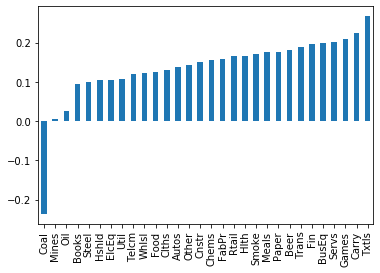

In [84]:
er.sort_values().plot.bar()

Finally, let's generate the covariance matrix. Fortunately, this is easy enough to do using the `.cov` method:

In [85]:
cov = ind["2013":"2017"].cov()
cov.shape

(30, 30)

In [86]:
l = ["Books", "Steel", "Oil", "Mines"]

In [87]:
er[l]

Books    0.095312
Steel    0.100716
Oil      0.025275
Mines    0.005136
dtype: float64

In [88]:
cov.loc[l,l]

,Books,Steel,Oil,Mines
Books,0.002720,0.001940,0.001637,0.001539
Steel,0.001940,0.004391,0.002122,0.003391
Oil,0.001637,0.002122,0.002697,0.002179
Mines,0.001539,0.003391,0.002179,0.005232


In [89]:
ew = np.repeat(0.25, 4)
erk.portfolio_return(ew, er[l])

0.05660970304537655

In [90]:
erk.portfolio_vol(ew, cov.loc[l,l])

0.05040901324689289

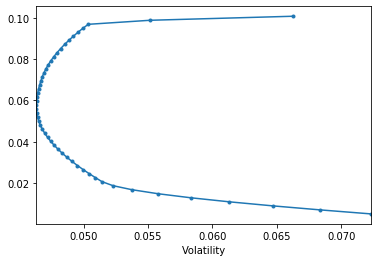

In [91]:
erk.plot_ef(50, er[l], cov.loc[l,l])

In [92]:
er[l]

Books    0.095312
Steel    0.100716
Oil      0.025275
Mines    0.005136
dtype: float64

In [93]:
cov.loc[l,l]

,Books,Steel,Oil,Mines
Books,0.002720,0.001940,0.001637,0.001539
Steel,0.001940,0.004391,0.002122,0.003391
Oil,0.001637,0.002122,0.002697,0.002179
Mines,0.001539,0.003391,0.002179,0.005232


In [94]:
erk.msr(0.1, er[l], cov.loc[l,l])

array([4.51375048e-15, 1.00000000e+00, 1.40512602e-16, 0.00000000e+00])

In [95]:
gmv = erk.gmv(cov.loc[l,l])

In [96]:
gmv

array([4.77024870e-01, 4.33680869e-19, 4.34112024e-01, 8.88631053e-02])

In [118]:
er2018 = erk.annualize_rets(ind["2018"], 12)

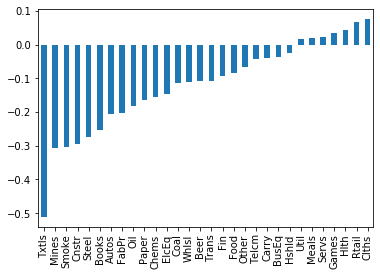

In [119]:
er2018.sort_values().plot.bar()

In [120]:
cov2018 = ind["2018"].cov()
cov2018.shape

(30, 30)

In [125]:
cov2018.loc[l,l]

,Books,Steel,Oil,Mines
Books,0.002799,0.002098,0.002558,0.001629
Steel,0.002098,0.004027,0.003473,0.001843
Oil,0.002558,0.003473,0.005296,0.001961
Mines,0.001629,0.001843,0.001961,0.002059


In [129]:
np.array([0, 1, 0, 0]).sum()

1

In [130]:
erk.portfolio_vol(np.array([0, 1, 0, 0]), cov2018.loc[l,l])*((12)**0.5)

0.21983988181484185

In [113]:
gmv = erk.gmv(cov)

In [114]:
gmv

array([2.62060606e-01, 1.52597039e-02, 1.21859892e-15, 7.22679691e-01])

In [131]:
np.array([2.62060606e-01, 1.52597039e-02, 1.21859892e-15, 7.22679691e-01]).sum()

1.0000000009000012

In [132]:
erk.portfolio_vol(np.array([2.62060606e-01, 1.52597039e-02, 1.21859892e-15, 7.22679691e-01]), cov)*(12**0.5)

0.15269232298232877

In [117]:
np.array([0.262060606, 0.0152597039, 0, 0.722679691]).sum()

1.0000000008999999

In [ ]:
r.